<a href="https://colab.research.google.com/github/Leonard2310/TrendAnalysis/blob/main/LSTMforStreamlitISBI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive Linking

In [1]:
from google.colab import drive                                                  # Import the Google Colab Drive module

drive.mount('/content/drive')                                                   # Base address of the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Library

In [2]:
!pip install tensorflow==2.16.2

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler


# Per i modelli di machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score

# Integrazione con Google Drive (se si usa Google Colab)
from google.colab import drive

# Data Import

In [12]:
!wget -O temp_humid_data.xlsx https://www.dropbox.com/scl/fi/326oxe283ly6tgtfqrf3p/temp_humid_data.xlsx?rlkey=e1errsfubga1jauvr9g6z8j3j&st=5v76nvon&dl=0

--2024-11-30 10:29:29--  https://www.dropbox.com/scl/fi/326oxe283ly6tgtfqrf3p/temp_humid_data.xlsx?rlkey=e1errsfubga1jauvr9g6z8j3j
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6176460f1f05d3aba8f998caa5.dl.dropboxusercontent.com/cd/0/inline/CfXlI_rV8bofq_wXJEaInijmwL1Crlx7xbP4mc7bMC-iVZACc6BNVu1TP0vxPywQBjEVNs5ugMlu6JWXhIFyZLo4lAATpxjjHk3HPuUHHovfVJjHM3KOpxWJKPFaSKGAOAeNhSXakqdcDclyyGSMWnJ3/file# [following]
--2024-11-30 10:29:30--  https://uc6176460f1f05d3aba8f998caa5.dl.dropboxusercontent.com/cd/0/inline/CfXlI_rV8bofq_wXJEaInijmwL1Crlx7xbP4mc7bMC-iVZACc6BNVu1TP0vxPywQBjEVNs5ugMlu6JWXhIFyZLo4lAATpxjjHk3HPuUHHovfVJjHM3KOpxWJKPFaSKGAOAeNhSXakqdcDclyyGSMWnJ3/file
Resolving uc6176460f1f05d3aba8f998caa5.dl.dropboxusercontent.com (uc6176460f1f05d3aba8f998caa5.dl.dropboxusercontent.com)... 162.125.5.15

In [13]:
# Replace with your file's path
file_path = '/content/temp_humid_data.xlsx'

# Read the third sheet (assuming it's the third by order)
df = pd.read_excel(file_path, sheet_name=1)

df.to_csv("seasonal_data.csv")

In [14]:
df.index = df.Date
del df["Date"]

In [15]:
df

,no. of Adult males,temperature_mean,relativehumidity_mean
Date,,,
2023-06-15,1,24.62,45
2023-06-16,1,26.79,46
2023-06-17,0,26.02,53
2023-06-18,1,25.04,48
2023-06-19,0,25.09,43
...,...,...,...
2023-09-24,0,18.19,50
2023-09-25,2,17.75,73
2023-09-26,0,17.70,77


# LSTM Training

In [7]:
#@title Definition

def train_lstm_model(df, n_lags=5,  target_col='no. of Adult males',  exog_cols=[], learning_rate=0.001,  batch_size=8, epochs=25):
    # Creazione delle feature laggate
    def create_lagged_features(df, n_lags, target_col, exog_cols):
        lagged_df = df.copy()
        for col in [target_col] + exog_cols:
            for i in range(1, n_lags + 1):
                lagged_df[f'{col}_lag_{i}'] = lagged_df[col].shift(i)
        lagged_df = lagged_df.dropna()
        return lagged_df

    lagged_df = create_lagged_features(df, n_lags=n_lags, target_col=target_col, exog_cols=exog_cols)

    variables = [target_col] + exog_cols
    timestep_cols = []
    for t in range(n_lags):
        lag = n_lags - t
        cols = [f'{var}_lag_{lag}' for var in variables]
        timestep_cols.append(cols)

    # Creazione di X e y
    X_list = [lagged_df[cols].values for cols in timestep_cols]
    X = np.stack(X_list, axis=1)
    y = lagged_df[target_col].values

    train_size = len(lagged_df) - 5  # Split train/test
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Scaling delle feature
    n_train_samples, n_timesteps, n_features = X_train.shape
    X_train_reshaped = X_train.reshape(-1, n_features)
    X_test_reshaped = X_test.reshape(-1, n_features)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(n_train_samples, n_timesteps, n_features)
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], n_timesteps, n_features)

    # Definizione del modello
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = tf.keras.layers.LSTM(50, activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Addestramento del modello
    history = model.fit(
        X_train_scaled, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_scaled, y_test),
        verbose=0
    )

    # Previsioni
    y_train_pred = model.predict(X_train_scaled).flatten()
    y_test_pred = model.predict(X_test_scaled).flatten()
    y_train_pred = np.clip(y_train_pred, 0, None).round()
    y_test_pred = np.clip(y_test_pred, 0, None).round()

    # Valutazione
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)

    # Residui
    residuals_train = y_train - y_train_pred

    # Plot
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # Grafico 1: Valori effettivi vs Predetti (Training)
    axs[0, 0].plot(y_train, label='Effettivi', color='blue', marker='o')
    axs[0, 0].plot(y_train_pred, label='Predetti', color='red', linestyle='--', marker='x')
    axs[0, 0].set_title(f'Training Data\nRMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}')
    axs[0, 0].set_xlabel('Osservazioni')
    axs[0, 0].set_ylabel('No. di adulti maschi')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Grafico 2: Residui (Training)
    axs[0, 1].plot(residuals_train, label='Residui', color='purple', marker='o')
    axs[0, 1].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axs[0, 1].set_title('Residui (Training)')
    axs[0, 1].set_xlabel('Osservazioni')
    axs[0, 1].set_ylabel('Residui')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Grafico 3: Perdita su Epoche
    axs[1, 0].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[1, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    axs[1, 0].set_title('Perdita durante le epoche')
    axs[1, 0].set_xlabel('Epoche')
    axs[1, 0].set_ylabel('Loss (MSE)')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Grafico 4: Valori Effettivi vs Predetti (Test)
    axs[1, 1].plot(y_test, label='Effettivi', marker='o', color='blue')
    axs[1, 1].plot(y_test_pred, label='Predetti', marker='x', linestyle='--', color='red')
    axs[1, 1].set_title(f'Test Data\nRMSE: {rmse_test:.2f}, MAE: {mae_test:.2f}')
    axs[1, 1].set_xlabel('Osservazioni')
    axs[1, 1].set_ylabel('No. di adulti maschi')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return model, scaler, history, rmse_train, mae_train, rmse_test, mae_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


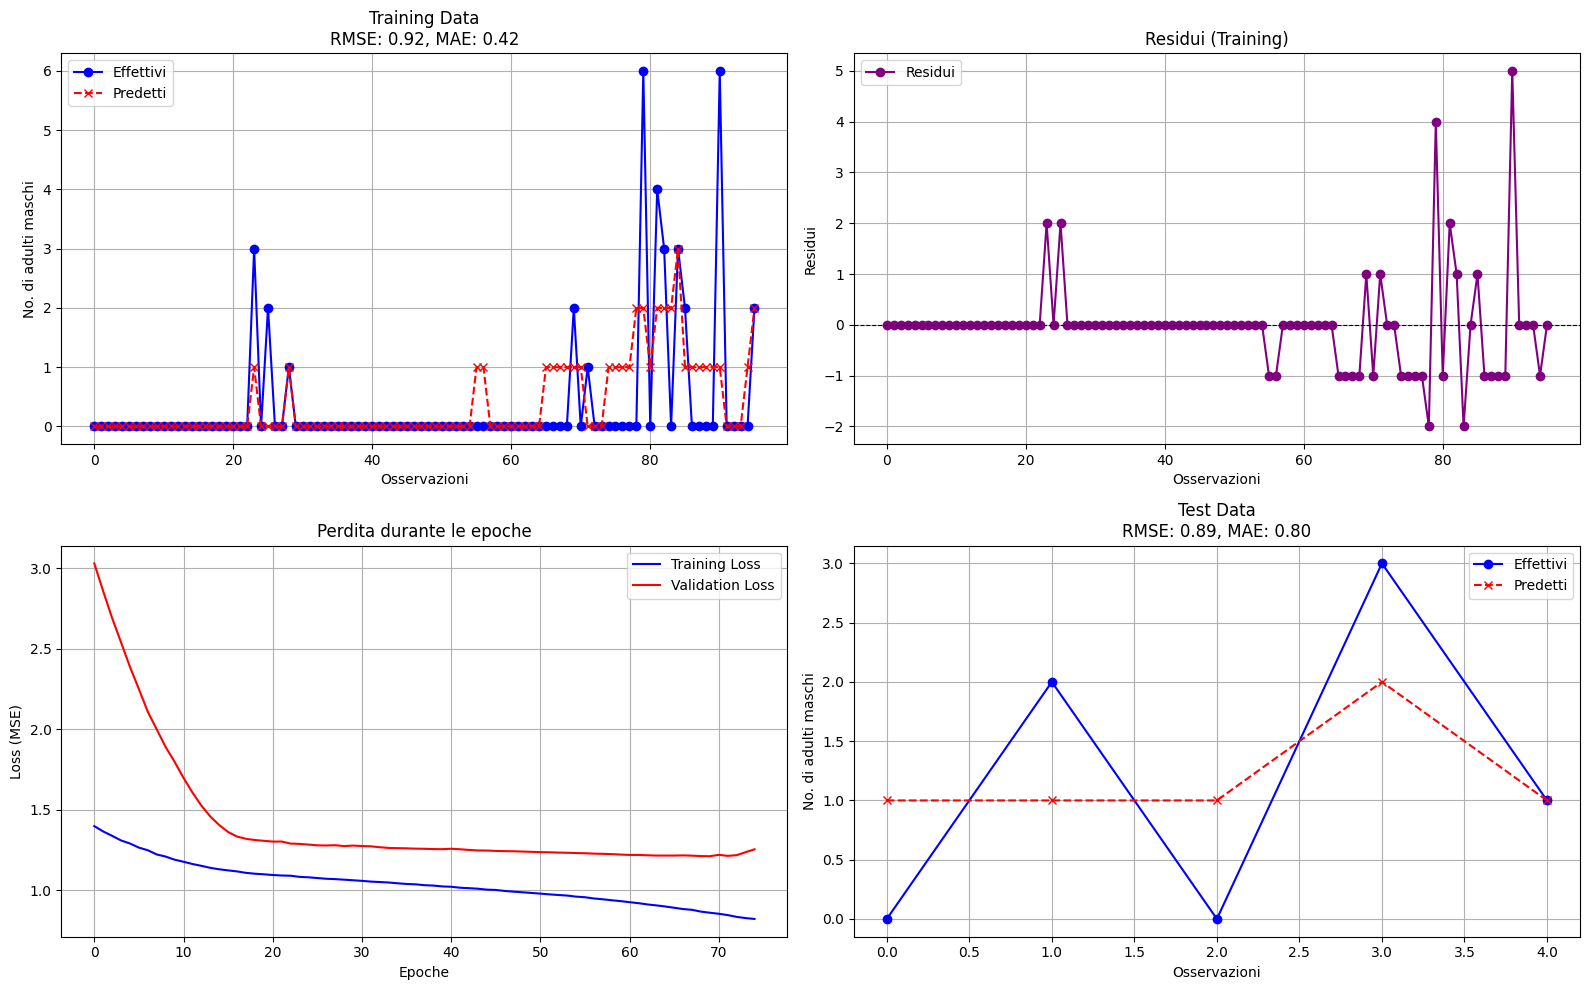

In [8]:
#@title Forecasting
model, scaler, history, rmse_train, mae_train, rmse_test, mae_test = train_lstm_model(
    df=df,
    n_lags=5,
    target_col='no. of Adult males',
    exog_cols=['temperature_mean', 'relativehumidity_mean'],
    learning_rate=0.0005,
    batch_size=20,
    epochs=75
)

# LSTM Saving

In [9]:
model.save("lstm_model.keras")